In [1]:
import torch
import torchvision
from torch import optim
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_V2_Weights, \
    fasterrcnn_resnet50_fpn_v2
from torchvision.datasets import VOCDetection
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from matplotlib import patches
import matplotlib.pyplot as plt


In [2]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, year="2007", image_set="train", transforms=None):
        self.dataset = VOCDetection(root, year=year, image_set=image_set, download=False)
        self.transforms = transforms


    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        img = F.to_tensor(img)


        boxes = []
        labels = []
        for obj in target['annotation']['object']:
            bbox = obj['bndbox']
            boxes.append([
            float(bbox['xmin']),
            float(bbox['ymin']),
            float(bbox['xmax']),
            float(bbox['ymax'])
        ])
            labels.append(1) # single-class example


        target = {
        "boxes": torch.tensor(boxes, dtype=torch.float32),
        "labels": torch.tensor(labels, dtype=torch.int64)
        }


        return img, target


    def __len__(self):
        return len(self.dataset)

In [3]:
def collate_fn(batch):
    return tuple(zip(*batch))


train_dataset = VOCDataset("./data", image_set="train")
val_dataset = VOCDataset("./data", image_set="val")

from torch.utils.data import Subset
train_dataset = Subset(train_dataset, range(100))
val_dataset = Subset(val_dataset, range(50))


train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True, persistent_workers=False)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [4]:
def train_one_epoch(model, loader, optimizer, device, epoch, epochs):
    model.train()
    running_loss = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)

    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    return running_loss / len(loader)


In [5]:
def evaluate(model, loader, device, epoch, epochs):
    model.train()  # detection models need train mode to return losses
    running_loss = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)

    with torch.no_grad():
        for images, targets in pbar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            running_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

    return running_loss / len(loader)


In [6]:
def train_model(model, train_loader, val_loader, optimizer, device, epochs):

    history = {
        "train_loss": [],
        "val_loss": []
    }

    for epoch in range(epochs):
        train_loss = train_one_epoch(
            model, train_loader, optimizer, device, epoch, epochs
        )

        val_loss = evaluate(
            model, val_loader, device, epoch, epochs
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f}"
        )

    return history


In [7]:
def plot_curves(results):
    plt.figure(figsize=(8,5))

    for name, hist in results.items():
        plt.plot(hist["train_loss"], label=f"{name} Train")
        plt.plot(hist["val_loss"], linestyle="--", label=f"{name} Val")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
def show_detection(model, dataset, device, n, score_thr=0.5):
    model.eval()

    import random
    idxs = random.sample(range(len(dataset)), n)

    for idx in idxs:
        img, target = dataset[idx]

        with torch.no_grad():
            pred = model([img.to(device)])[0]

        img_np = img.permute(1,2,0).cpu().numpy()

        plt.figure(figsize=(6,6))
        plt.imshow(img_np)
        ax = plt.gca()

        # GT boxes (green)
        for box in target["boxes"]:
            x1,y1,x2,y2 = box
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                     linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

        # Pred boxes (red)
        for box, score in zip(pred["boxes"], pred["scores"]):
            if score < score_thr:
                continue
            x1,y1,x2,y2 = box.cpu()
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        plt.title("Green=GT, Red=Prediction")
        plt.axis("off")
        plt.show()


In [ ]:
def create_model(num_classes, device):
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn_v2(weights=weights)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )

    return model.to(device)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Training with epochs=5


Epoch 1/5 | Train Loss: 0.9651 | Val Loss: 0.5121


Epoch 2/5 | Train Loss: 0.3863 | Val Loss: 0.3305


Epoch 3/5 | Train Loss: 0.2443 | Val Loss: 0.2867


Epoch 4/5 | Train Loss: 0.1967 | Val Loss: 0.2751


Epoch 5/5 | Train Loss: 0.1586 | Val Loss: 0.2687
Training with epochs=10


Epoch 1/10 | Train Loss: 0.1501 | Val Loss: 0.2692


Epoch 2/10 | Train Loss: 0.1337 | Val Loss: 0.2735


Epoch 3/10 | Train Loss: 0.1235 | Val Loss: 0.2704


Epoch 4/10 | Train Loss: 0.1115 | Val Loss: 0.2695


Epoch 5/10 | Train Loss: 0.1059 | Val Loss: 0.2668


Epoch 6/10 | Train Loss: 0.0990 | Val Loss: 0.2781


Epoch 7/10 | Train Loss: 0.0927 | Val Loss: 0.2702


Epoch 8/10 | Train Loss: 0.0842 | Val Loss: 0.2811


Epoch 9/10 | Train Loss: 0.0781 | Val Loss: 0.2833


Epoch 10/10 | Train Loss: 0.0791 | Val Loss: 0.2887
Training with epochs=15


Epoch 1/15 | Train Loss: 0.0762 | Val Loss: 0.2943


Epoch 2/15 | Train Loss: 0.0737 | Val Loss: 0.2973


Epoch 3/15 | Train Loss: 0.0703 | Val Loss: 0.3007


Epoch 4/15 | Train Loss: 0.0643 | Val Loss: 0.2985


Epoch 5/15 | Train Loss: 0.0633 | Val Loss: 0.3050


Epoch 6/15 | Train Loss: 0.0613 | Val Loss: 0.3083


Epoch 7/15 | Train Loss: 0.0568 | Val Loss: 0.3047


Epoch 8/15 | Train Loss: 0.0592 | Val Loss: 0.3070


Epoch 9/15 | Train Loss: 0.0601 | Val Loss: 0.3037


Epoch 10/15 | Train Loss: 0.0554 | Val Loss: 0.3012


Epoch 11/15 | Train Loss: 0.0542 | Val Loss: 0.3078


Epoch 12/15 | Train Loss: 0.0524 | Val Loss: 0.3066


Epoch 13/15 | Train Loss: 0.0497 | Val Loss: 0.3095


Epoch 14/15 | Train Loss: 0.0509 | Val Loss: 0.3130


Epoch 15/15 | Train Loss: 0.0481 | Val Loss: 0.3166


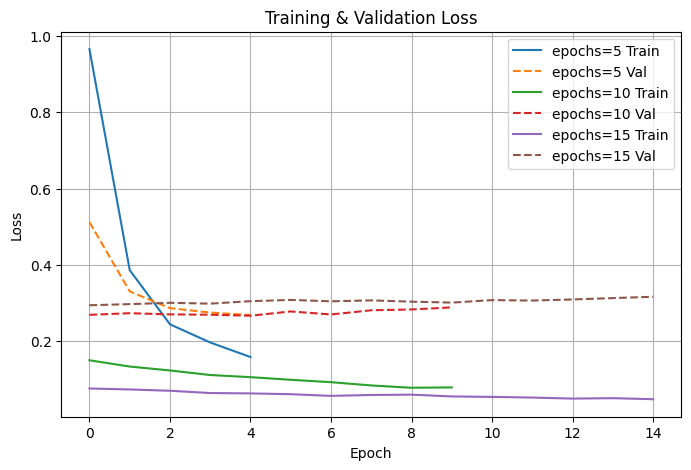

In [10]:
results = {}

for epochs in [5, 10, 15]:
    print(f"Training with epochs={epochs}")

    model = model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    history = train_model(model, train_loader, val_loader, optimizer, device, epochs)

    results[f"epochs={epochs}"] = history

plot_curves(results)

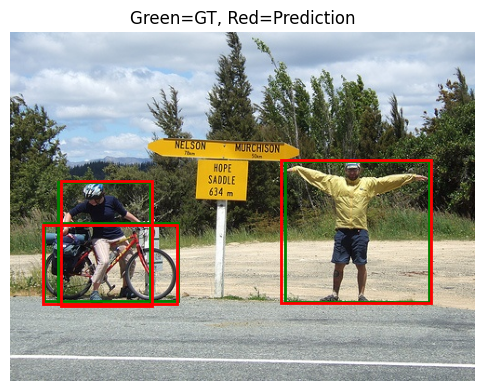

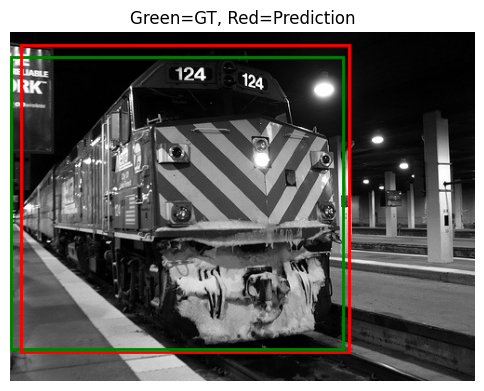

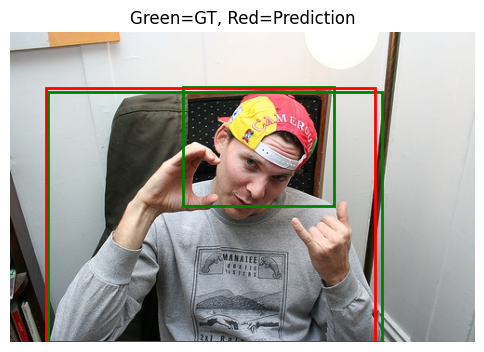

In [11]:
show_detection(model, val_dataset, device, n=8)